In [8]:
import matplotlib.pyplot as plt
import numpy as np
from ambiance import Atmosphere

# Constants
H = [0,10000]                                                                         #[m]
P0_range = [Atmosphere(H[0]).pressure[0], Atmosphere(H[1]).pressure[0]]               #[kPa]
T0_range = [Atmosphere(H[0]).temperature[0], Atmosphere(H[1]).temperature[0]]         #[K]
C0_range =  [80,240]                                                                  #[m/s]
a0_range = [Atmosphere(H[0]).speed_of_sound[0], Atmosphere(H[1]).speed_of_sound[0]]   #[m/s]
T04_range = np.arange(1200,1700+100,100).tolist()                                     #[K]
BPR_range = np.arange(5,15+2.5,2.5).tolist()                                          #Bypass Ratio
CPR_range = np.arange(5,40+5,5.0).tolist()                                              #Compressor Pressure Ratio
FPR_range = np.arange(1.5,3+0.25,0.25).tolist()                                       #Fan Pressure Ratio

R = 0.287       #[kJ/kg-K]
Cpa = 1.005  #[kJ/kg-K]
gamma_a = 1.4     #[-]
gamma_g = 1.333 #[-] 
eff_i = 1       #Inlet Isentropic Efficiency
eff_f = 1       #Fan Isentropic Efficiency
eff_fN = 1      #Fan Nozzle Isentropic Efficiency
eff_c = 1       #Compressor Isentropic Efficiency
Cpg = 1.148     #[kJ/kg-K]
eff_b = 1       #Burner Efficiency
eff_t = 1       #Turbine Isentropic Efficiency
eff_m = 1       #Mechanical Efficiency
eff_n = 1       #Core-Nozzle Efficiency
LHV = 43400     #[kJ/kg]
DELTA_Pb = 0    #Pressure Loss in Burner


def TurboFan(FPR,T04_inlet,T0,C0,a0,P0,BPR,CPR):
    # Inlet
    T02 = T0 * (1 + ((gamma_a - 1) / (2)) * (C0 / a0)**2)
    P02 = P0 * (1 + eff_i * ((gamma_a-1)/(2)) * (C0/a0)**2)**((gamma_a) / (gamma_a-1))


    # Fan
    T013 = T02*(1+(1/eff_f)*(FPR**((gamma_a-1)/(gamma_a))-1))
    P013 = P02 * FPR

    # Fan Nozzle
    RCE = 1 / ((1 - (1 / eff_fN) * ((gamma_a - 1) / (gamma_a + 1)))**(gamma_a / (gamma_a - 1)))
    if (P013 / P0) >= RCE:
        T019 = T013
        P_c19 = P013 / RCE
        P19 = P_c19
        T_cr19 = T019 * (2 / (gamma_a + 1))
        T19 = T_cr19
        C19 = np.sqrt(gamma_a * R * T19 * 1E3)
    else:
        P19 = P0
        T19 = T013 * (1 - eff_fN * (1 - (P19 / P013)**((gamma_a - 1) / gamma_a)))

        C19 = np.sqrt(2 * Cpa * (T013 - T19) * 1E3)
    
    # Compressor
    P03 = P013 * CPR
    T03 = T013 * (1 + (1 / eff_c) * (CPR**((gamma_a - 1) / gamma_a) - 1))

    # Burner
    T04 = T04_inlet
    f = (Cpg * T04 - Cpa * T03) / (eff_b * LHV - Cpg * T04)
    P04 = P03 - DELTA_Pb

    # Turbine
    T05 = T04 - ((T03 - T02) + BPR * (T013 - T02)) / (eff_m * (1 + f) * (Cpg / Cpa))

    P05 = P04 * (1 - ((T04 - T05) / (eff_t * T04)))**(gamma_g / (gamma_g - 1))

    # Core Nozzle
    T07 = T05
    P07 = P05
    RCI = 1 / ((1 - (1 / eff_n) * ((gamma_g - 1) / (gamma_g + 1)))**(gamma_g / (gamma_g - 1)))
    if (P07 / P0) >= RCI:
        T09 = T07
        P_c9 = P07 / RCI
        P9 = P_c9
        T_cr9 = T09 * (2 / (gamma_g + 1))
        T9 = T_cr9
        C9 = np.sqrt(gamma_g * R * T9 * 1E3)
    else:
        P9 = P0
        T9 = T07 * (1 - eff_n * (1 - (P9 / P07)**((gamma_g - 1) / gamma_g)))
        C9 = np.sqrt(2 * Cpg * (T07 - T9) * 1E3)

    M9 = C9 / a0
    M19 = C19 / a0

    ST = (1 + f) * (C9 / (1 + BPR)) * (1 + (1 / (gamma_g * M9**2)) * (1 - (P0 / P9))) + (BPR * C19 / (1 + BPR)) * (1 + (1 / (gamma_a * M19**2)) * (1 - (P0 / P19))) - C0

    SFC = (1 / (1 + BPR)) * (f / ST)

    SFC = SFC * ((3600*2.204)/(0.2248)) #Convert to lbm/h/lbf


    return ST, SFC,f
ST_results = np.zeros((len(C0_range),len(CPR_range),len(BPR_range),len(T04_range),len(FPR_range)))
SFC_results = np.zeros((len(C0_range),len(CPR_range),len(BPR_range),len(T04_range),len(FPR_range)))
f_results = np.zeros((len(C0_range),len(CPR_range),len(BPR_range),len(T04_range),len(FPR_range)))

for z in range(len(C0_range)):
    for x in range(len(CPR_range)):
        for y in range(len(BPR_range)):
            for tit in range(len(T04_range)):
                for fpr in range(len(FPR_range)):
                    
                    ST, SFC,f = TurboFan(FPR_range[fpr],T04_range[tit],T0_range[z],C0_range[z],a0_range[z],P0_range[z],BPR_range[y],CPR_range[x])

                    ST_results[z][x][y][tit][fpr] = ST
                    SFC_results[z][x][y][tit][fpr] = SFC
                    f_results[z][x][y][tit][fpr] = f

/tmp/ipykernel_5710/3807114749.py:86: RuntimeWarning: invalid value encountered in sqrt
  C9 = np.sqrt(2 * Cpg * (T07 - T9) * 1E3)
/tmp/ipykernel_5710/3807114749.py:70: RuntimeWarning: invalid value encountered in scalar power
  P05 = P04 * (1 - ((T04 - T05) / (eff_t * T04)))**(gamma_g / (gamma_g - 1))


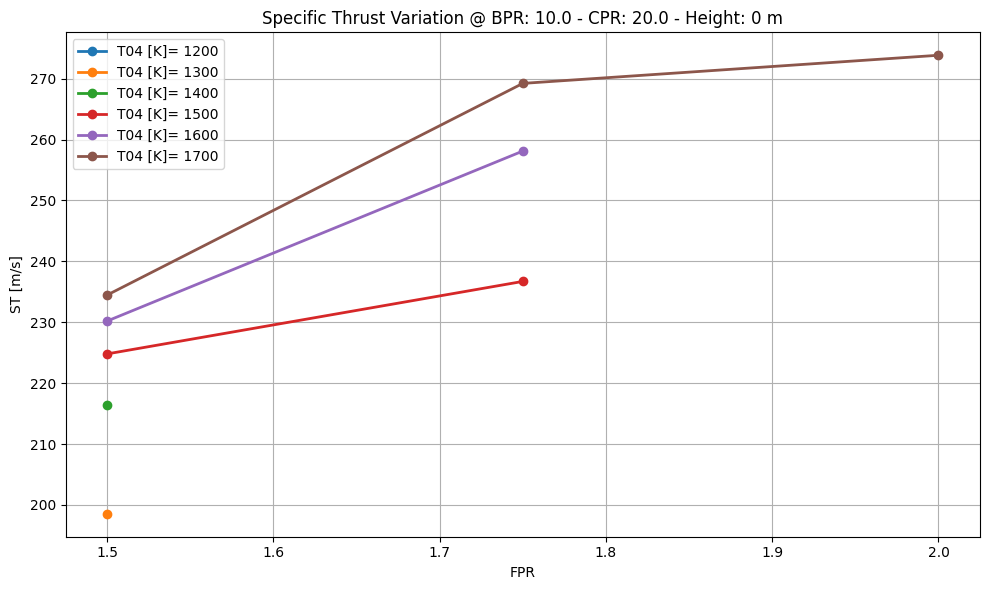

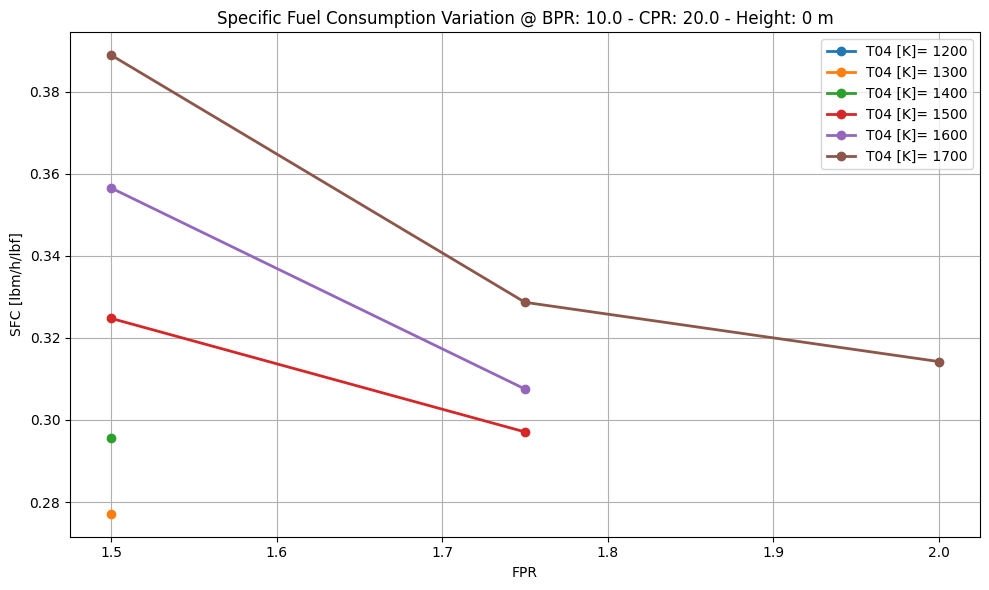

In [9]:
i_H =   0       #Atmospheric Run    [0-1]
i_CPR = 3       #CPR Run            [0-7]
i_BPR = 2       #BPR Run            [0-4]


# Plot for Specific Thrust Variation
plt.figure(figsize=(10, 6))

for i, T04_inlet in enumerate(T04_range):
    plt.plot(FPR_range, ST_results[i_H][i_CPR][i_BPR][i], "o-", label=f'T04 [K]= {T04_inlet}', linewidth=2)

plt.xlabel('FPR')
plt.ylabel('ST [m/s]')
plt.title(f'Specific Thrust Variation @ BPR: {BPR_range[i_BPR]} - CPR: {CPR_range[i_CPR]} - Height: {H[i_H]} m')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for Specific Fuel Consumption Variation
plt.figure(figsize=(10, 6))
for i, T04_inlet in enumerate(T04_range):
    plt.plot(FPR_range, SFC_results[i_H][i_CPR][i_BPR][i], "o-",label=f'T04 [K]= {T04_inlet}', linewidth=2)

plt.xlabel('FPR')
plt.ylabel('SFC [lbm/h/lbf]')
plt.title(f'Specific Fuel Consumption Variation @ BPR: {BPR_range[i_BPR]} - CPR: {CPR_range[i_CPR]} - Height: {H[i_H]} m')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

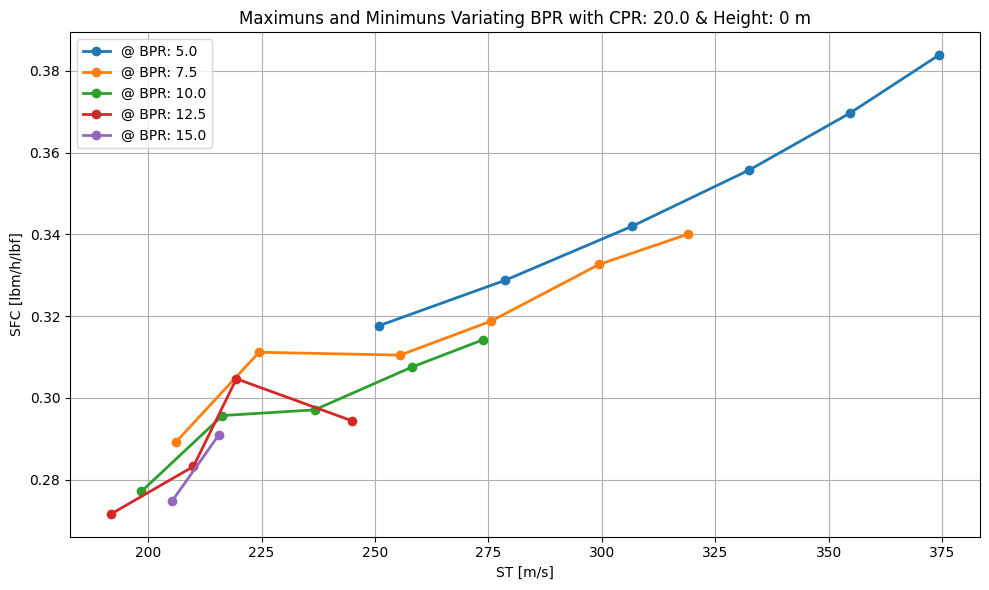

In [10]:
max_ST_BPR = []
min_SFC_BPR = []

max_optimun_ST = []
min_optimun_SFC = []

for i in range(len(BPR_range)):
    aux_max_ST_BPR = []
    aux_min_SFC_BPR = []
    for j in range(len(T04_range)):
        max_ST_T04 = max(ST_results[i_H][i_CPR][i][j])
        min_SFC_T04 = min(SFC_results[i_H][i_CPR][i][j])

        aux_max_ST_BPR.append(max_ST_T04)
        aux_min_SFC_BPR.append(min_SFC_T04)

    max_ST_BPR.append(aux_max_ST_BPR)
    min_SFC_BPR.append(aux_min_SFC_BPR)

    max_optimun_ST.append(max(max_ST_BPR[i]))
    min_optimun_SFC.append(min(min_SFC_BPR[i]))

# Plot for Specific Fuel Consumption Variation
plt.figure(figsize=(10, 6))
for i, bpr in enumerate(BPR_range):
    plt.plot(max_ST_BPR[i], min_SFC_BPR[i], "o-",label=f'@ BPR: {bpr}', linewidth=2)

plt.xlabel('ST [m/s]')
plt.ylabel('SFC [lbm/h/lbf]')
plt.title(f'Maximuns and Minimuns Variating BPR with CPR: {CPR_range[i_CPR]} & Height: {H[i_H]} m')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

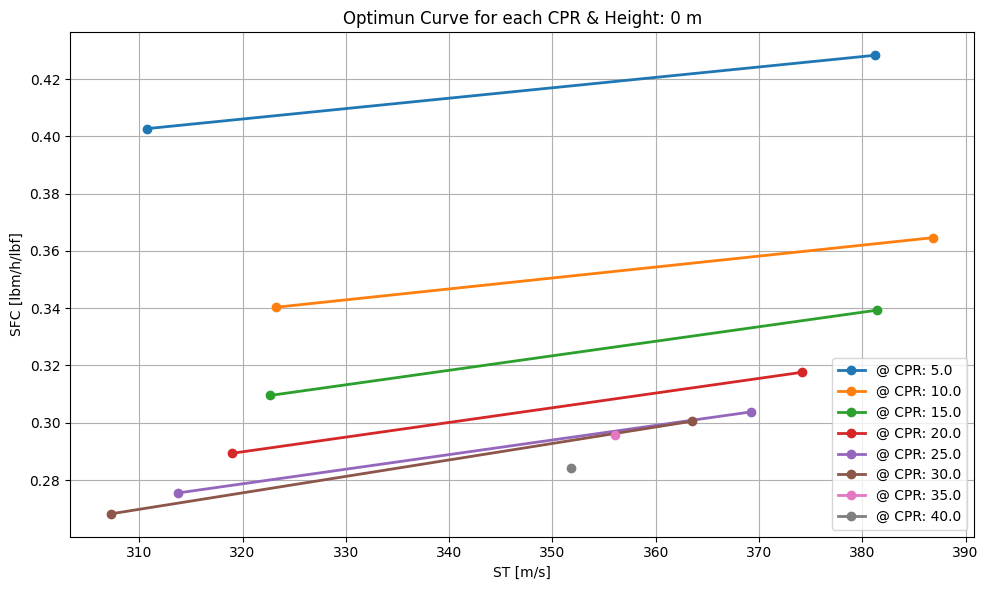

list

In [11]:
max_optimun_ST_CPR = []
min_optimun_SFC_CPR = []

for i in range(len(CPR_range)):
    max_ST_BPR = []
    min_SFC_BPR = []

    max_optimun_ST = []
    min_optimun_SFC = []

    for j in range(len(BPR_range)):
        aux_max_ST_BPR = []
        aux_min_SFC_BPR = []
        
        for k in range(len(T04_range)):
            max_ST_T04 = max(ST_results[i_H][i][j][k])
            min_SFC_T04 = min(SFC_results[i_H][i][j][k])
            
            aux_max_ST_BPR.append(max_ST_T04)
            aux_min_SFC_BPR.append(min_SFC_T04)
        
        max_ST_BPR.append(aux_max_ST_BPR)
        min_SFC_BPR.append(aux_min_SFC_BPR)

        max_optimun_ST.append(max(max_ST_BPR[j]))
        min_optimun_SFC.append(min(min_SFC_BPR[j]))
    
    max_optimun_ST_CPR.append(max_optimun_ST)
    min_optimun_SFC_CPR.append(min_optimun_SFC)


plt.figure(figsize=(10, 6))
for i, cpr in enumerate(CPR_range):
    plt.plot(max_optimun_ST_CPR[i], min_optimun_SFC_CPR[i], "o-",label=f'@ CPR: {cpr}', linewidth=2)
plt.xlabel('ST [m/s]')
plt.ylabel('SFC [lbm/h/lbf]')
plt.title(f'Optimun Curve for each CPR & Height: {H[i_H]} m')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

type(max_optimun_ST_CPR)

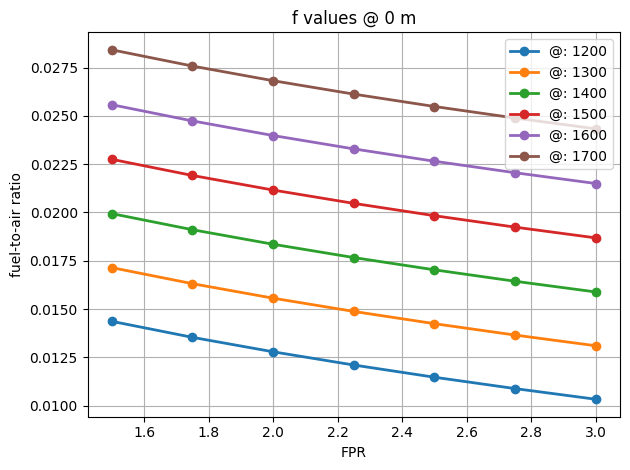

In [12]:
for i,tit in enumerate(T04_range):
    plt.plot(FPR_range, f_results[i_H][i_CPR][i_BPR][i], "o-",label=f'@: {tit}', linewidth=2)

plt.xlabel('FPR')
plt.ylabel('fuel-to-air ratio')
plt.title(f'f values @ {H[i_H]} m')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

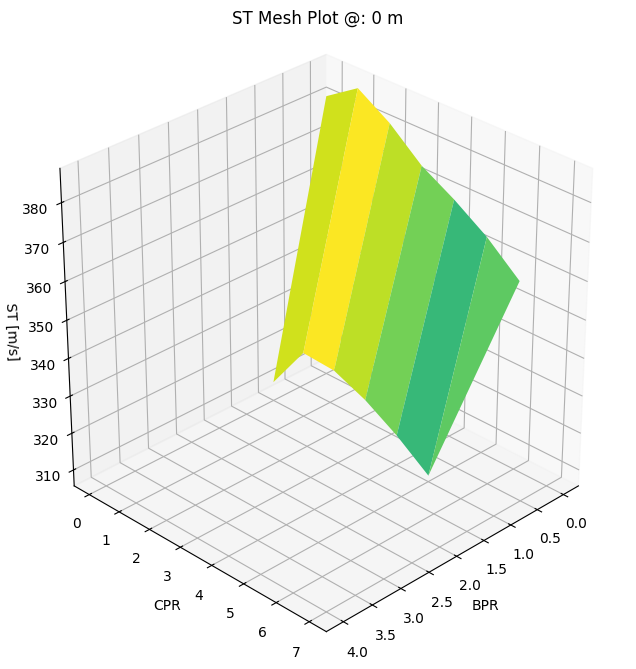

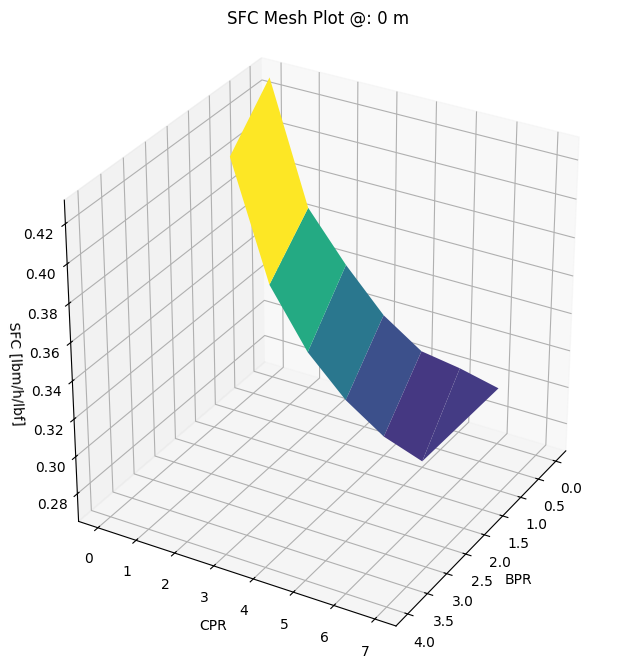

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert the list of lists to a numpy array
max_optimun_ST_CPR_array = np.array(max_optimun_ST_CPR)

# Create meshgrid for indices
x = np.arange(max_optimun_ST_CPR_array.shape[1])
y = np.arange(max_optimun_ST_CPR_array.shape[0])
X, Y = np.meshgrid(x, y)

# Plotting
fig = plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
ax = fig.add_subplot(111, projection='3d')

# Flatten the array and plot as a surface
ax.plot_surface(X, Y, max_optimun_ST_CPR_array, cmap='viridis')

# Customize the plot (optional)
ax.set_xlabel('BPR')
ax.set_ylabel('CPR')
ax.set_zlabel('ST [m/s]')
ax.set_title(f'ST Mesh Plot @: {H[i_H]} m')

# Adjust aspect ratio
ax.set_box_aspect([1, 1, 1])  # Adjust the third value as needed to fit in the window properly

# Rotate the plot
ax.view_init(elev=30, azim=45)

plt.show()


# Convert the list of lists to a numpy array
min_optimun_SFC_CPR_array = np.array(min_optimun_SFC_CPR)

# Create meshgrid for indices
x = np.arange(min_optimun_SFC_CPR_array.shape[1])
y = np.arange(min_optimun_SFC_CPR_array.shape[0])
X, Y = np.meshgrid(x, y)

# Plotting
fig = plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
ax = fig.add_subplot(111, projection='3d')

# Flatten the array and plot as a surface
ax.plot_surface(X, Y, min_optimun_SFC_CPR_array, cmap='viridis')

# Customize the plot (optional)
ax.set_xlabel('BPR')
ax.set_ylabel('CPR')
ax.set_zlabel('SFC [lbm/h/lbf]')
ax.set_title(f'SFC Mesh Plot @: {H[i_H]} m')

# Adjust aspect ratio
ax.set_box_aspect([1, 1, 1])  # Adjust the third value as needed to fit in the window properly

# Rotate the plot
ax.view_init(elev=30, azim=30)

plt.show()

In [14]:
#Thrust calculations
rho=[Atmosphere(H[0]).density[0],Atmosphere(H[1]).density[0]] #obtain atmosphere density from ISA
mdot_a=[]
D=81/39.37 # Diameter [m]
A=np.pi*(D/2)**2 #Fan area [m²]
i=0
for C in C0_range:
    mdot_a.append( rho[i] * A * C)
    
    i+=1

SFC_Optimal=380

T_C0=mdot_a[0]*SFC_Optimal
T_C1=mdot_a[1]*SFC_Optimal

print(f"TakeOff thrust:{T_C0}N, \nCruise @10.000m thrust:{T_C1}N")

#Carbon Footprint calculations

er_A1=3 #kgCO2/KgA1  
t=3600 #s
engines=2  
pax=146 

mdot_f=mdot_a[1]*0.019

def CO2fp(mdot_f,  er_A1,  t,  engines, pax):
    CO2fp = (mdot_f * er_A1 * t * engines) / pax
    return CO2fp

print(f"{engines*CO2fp(mdot_f,  er_A1,  t,  engines, pax)} KGC02/PAX")

TakeOff thrust:123805.16642005963N, 
Cruise @10.000m thrust:125374.81081023262N
1854.8602147267295 KGC02/PAX
